# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# # using SQLite Table to read data.
# con = sqlite3.connect('database.sqlite') 

# # filtering only positive and negative reviews i.e. 
# # not taking into consideration those reviews with Score=3
# # SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# # you can change the number to any other number based on your computing power

# # filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# # for tsne assignment you can take 5k data points

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# # Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
# def partition(x):
#     if x < 3:
#         return 0
#     return 1

# #changing reviews with score less than 3 to be positive and vice-versa
# actualScore = filtered_data['Score']
# positiveNegative = actualScore.map(partition) 
# filtered_data['Score'] = positiveNegative
# print("Number of data points in our data", filtered_data.shape)
# filtered_data.head(3)

In [3]:
# display = pd.read_sql_query("""
# SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
# FROM Reviews
# GROUP BY UserId
# HAVING COUNT(*)>1
# """, con)

In [4]:
# print(display.shape)
# display.head()

In [5]:
# display[display['UserId']=='AZY10LLTJ71NX']

In [6]:
# display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND UserId="AR5J8UI46CURR"
# ORDER BY ProductID
# """, con)
# display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
# #Sorting data according to ProductId in ascending order
# sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
# #Deduplication of entries
# final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
# final.shape

In [10]:
# #Checking to see how much % of data still remains
# (final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND Id=44737 OR Id=64422
# ORDER BY ProductID
# """, con)

# display.head()

In [12]:
# final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
# #Before starting the next phase of preprocessing lets see the number of entries left
# print(final.shape)

# #How many positive and negative reviews are present in our dataset?
# final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# # printing some random reviews
# sent_0 = final['Text'].values[0]
# print(sent_0)
# print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

In [15]:
# # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
# sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

# print(sent_0)

In [16]:
# # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
# from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

In [17]:
# # https://stackoverflow.com/a/47091490/4084039
# import re

# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

In [18]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [19]:
# #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
# sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
# print(sent_0)

In [20]:
# #remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [21]:
# # https://gist.github.com/sebleier/554280
# # we are removing the words from the stop words list: 'no', 'nor', 'not'
# # <br /><br /> ==> after the above steps, we are getting "br br"
# # we are including them into stop words list
# # instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

# stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
#             "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
#             'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
#             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
#             'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
#             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
#             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
#             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
#             'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
#             'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
#             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
#             've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
#             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
#             "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
#             'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# # Combining all the above stundents 
# from tqdm import tqdm
# preprocessed_reviews = []
# # tqdm is for printing the status bar
# for sentance in tqdm(final['Text'].values):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     # https://gist.github.com/sebleier/554280
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
#     preprocessed_reviews.append(sentance.strip())

In [23]:
# preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [26]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [27]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [28]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [29]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [30]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# Data Loading

In [34]:
clean_text_data=pd.read_csv("./input/Clean_data.csv")

In [35]:
clean_text_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [36]:
avg_w2v_df=pd.read_csv("./input/avg_w2v_df.csv")
tfidf_w2v_df=pd.read_csv("./input/tfidf_w2v_df.csv")
print(" avg_w2v_df ",avg_w2v_df.shape,"tfidf_w2v_df ",tfidf_w2v_df.shape,"clean_text_data",clean_text_data.shape)

 avg_w2v_df  (364171, 52) tfidf_w2v_df  (364171, 52) clean_text_data (364171, 11)


In [37]:
avg_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.758505,-0.172168,-0.385203,-0.241811,-0.394415,-0.073644,-0.22428,0.286488,-0.087994,-0.419489,...,-0.957424,0.008468,-0.998245,-0.097955,0.065205,-0.238957,-0.527055,0.183418,1.0,1.303862e+09


In [38]:
tfidf_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.631241,-0.058037,-0.317851,-0.147253,-0.524769,0.303866,-0.254059,0.337368,0.037931,-0.362123,...,-0.997835,0.090512,-0.722301,-0.040754,-0.208076,-0.658077,-0.648217,0.04987,1.0,1.303862e+09


In [39]:
# Checking the positive and negative labels
clean_text_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [40]:
#Spliting records into train, cv and test using based on time

def split_train_cv_test(df,sample_size):
    filter_data_positive=df[df.Score==1].sample(sample_size,random_state=17)
    filter_data_positive.sort_values(by='Time',inplace=True,ascending=True)
    filter_data_negative=df[df.Score==0].sample(sample_size,random_state=17)
    filter_data_negative.sort_values(by='Time',inplace=True,ascending=True)
    # Splitting Train,CV and Test for positive data
    row=filter_data_positive.shape[0]
    split=int(row*0.6)
    train_data_positive=filter_data_positive[:split]
    cv_data_positive=filter_data_positive[split:int(row*0.8)]
    test_data_positive=filter_data_positive[int(row*0.8):row]
    print("Total_positive_data",filter_data_positive.shape)
    print("train",train_data_positive.shape,"CV",cv_data_positive.shape,"test",test_data_positive.shape)
    # Splitting Train,CV and Test for -ve data
    row=filter_data_negative.shape[0]
    split=int(row*0.6)
    train_data_negative=filter_data_negative[:split]
    cv_data_negative=filter_data_negative[split:int(row*0.8)]
    test_data_negative=filter_data_negative[int(row*0.8):row]
    print("Total_negative_data",filter_data_negative.shape)
    print("train",train_data_negative.shape,"CV",cv_data_negative.shape,"test",test_data_negative.shape)
    # Combining +ve and -ve train data and sorting based on time
    train_data=np.vstack((train_data_positive, train_data_negative))
    train_data=pd.DataFrame(train_data)
    train_data.columns=df.columns
    train_data.sort_values(by='Time',inplace=True,ascending=True)
    print("train_data",train_data.shape)
    # Checking the positive and negative labels
    train_data['Score'].value_counts()
    # Combining +ve and -ve CV data and sorting based on time
    cv_data=np.vstack((cv_data_positive,cv_data_negative))
    cv_data=pd.DataFrame(cv_data)
    cv_data.columns=df.columns
    cv_data.sort_values(by='Time',inplace=True,ascending=True)
    print("cv_data",cv_data.shape)
    # Checking the positive and negative labels
    cv_data['Score'].value_counts()
    # Combining +ve and -ve test data and sorting based on time
    test_data=np.vstack((test_data_positive, test_data_negative))
    test_data=pd.DataFrame(test_data)
    test_data.columns=df.columns
    test_data.sort_values(by='Time',inplace=True,ascending=True)
    print("test_data",test_data.shape)
    # Checking the positive and negative labels
    test_data['Score'].value_counts()
    return train_data,cv_data,test_data

In [41]:
# splitting text data for BOW and TFIDF
train_text_data,cv_text_data,test_text_data=split_train_cv_test(clean_text_data,50000)

Total_positive_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)
Total_negative_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)
train_data (60000, 11)
cv_data (20000, 11)
test_data (20000, 11)


In [42]:
# splitting avg Word2Vec data
train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data=split_train_cv_test(avg_w2v_df,30000)

Total_positive_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
Total_negative_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
train_data (36000, 52)
cv_data (12000, 52)
test_data (12000, 52)


In [43]:
# splitting TFIDF Word2Vec data
train_tfidf_w2v_data,cv_tfidf_w2v_data,test_tfidf_w2v_data=split_train_cv_test(tfidf_w2v_df,30000)

Total_positive_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
Total_negative_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
train_data (36000, 52)
cv_data (12000, 52)
test_data (12000, 52)


In [44]:
train_tfidf_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.184549,-0.468398,1.121426,-0.017792,0.00297,-1.454604,0.554264,0.349232,0.107937,-0.539893,...,0.57634,-0.039829,-0.028913,1.05411,0.81801,0.258794,0.055568,0.387729,0.0,948240000.0


In [45]:
train_tfidf_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.184549,-0.468398,1.121426,-0.017792,0.00297,-1.454604,0.554264,0.349232,0.107937,-0.539893,...,0.57634,-0.039829,-0.028913,1.05411,0.81801,0.258794,0.055568,0.387729,0.0,948240000.0


In [46]:
train_text_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [47]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
import gc; gc.collect()
# Converting text to vector using Bag of words to all train, CV and test
count_vect = CountVectorizer(min_df=10,max_features=1000 ) #in scikit-learn
training_counts = count_vect.fit_transform(train_text_data['CleanedText'])
cv_counts = count_vect.transform(cv_text_data['CleanedText'])
test_counts = count_vect.transform(test_text_data['CleanedText'])
gc.collect()

0

In [48]:
# converting sparse vector to dense vector
training_count=training_counts.toarray()
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()
train_traget=train_text_data['Score'].astype('int')
cv_target=cv_text_data['Score'].astype('int')
test_target=test_text_data['Score'].astype('int')

 training_counts  (60000, 1000) cv_counts  (20000, 1000) test_counts (20000, 1000)


In [49]:
# Compute train AUC also

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
depth=[1, 5, 10, 50, 100, 500, 1000]
min_sample=[5, 10, 100, 500]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(depth):
    for j in tqdm(min_sample):
        # instantiate learning model
        clf = DecisionTreeClassifier(criterion='gini', max_depth=i, min_samples_split=j)
        # fitting the model on crossvalidation train
        clf.fit(training_count, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_count)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(training_count))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  1  min_sample to break:  5  AUC:  0.62185  Acc:  62.185  auc_train  0.61685



 25%|█████████████████████                                                               | 1/4 [00:01<00:04,  1.47s/it]

 depth value:  1  min_sample to break:  10  AUC:  0.62185  Acc:  62.185  auc_train  0.61685



 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.45s/it]

 depth value:  1  min_sample to break:  100  AUC:  0.62185  Acc:  62.185  auc_train  0.61685



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:04<00:01,  1.36s/it]

 depth value:  1  min_sample to break:  500  AUC:  0.62185  Acc:  62.185  auc_train  0.61685



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  5  min_sample to break:  5  AUC:  0.6804500000000001  Acc:  68.045  auc_train  0.6833333333333335



 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.15s/it]

 depth value:  5  min_sample to break:  10  AUC:  0.6804000000000001  Acc:  68.04  auc_train  0.6833333333333335



 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.15s/it]

 depth value:  5  min_sample to break:  100  AUC:  0.6804999999999999  Acc:  68.05  auc_train  0.6831833333333334



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.14s/it]

 depth value:  5  min_sample to break:  500  AUC:  0.67995  Acc:  67.995  auc_train  0.6826500000000001



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  10  min_sample to break:  5  AUC:  0.7453500000000001  Acc:  74.535  auc_train  0.7621666666666667



 25%|█████████████████████                                                               | 1/4 [00:09<00:27,  9.02s/it]

 depth value:  10  min_sample to break:  10  AUC:  0.7464000000000001  Acc:  74.64  auc_train  0.7617000000000002



 50%|██████████████████████████████████████████                                          | 2/4 [00:18<00:18,  9.02s/it]

 depth value:  10  min_sample to break:  100  AUC:  0.74575  Acc:  74.575  auc_train  0.7554333333333334



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:26<00:08,  8.99s/it]

 depth value:  10  min_sample to break:  500  AUC:  0.7428  Acc:  74.28  auc_train  0.7472833333333333



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  50  min_sample to break:  5  AUC:  0.7564  Acc:  75.64  auc_train  0.9512166666666666



 25%|█████████████████████                                                               | 1/4 [00:26<01:20, 26.75s/it]

 depth value:  50  min_sample to break:  10  AUC:  0.7569999999999999  Acc:  75.7  auc_train  0.9357666666666666



 50%|██████████████████████████████████████████                                          | 2/4 [00:54<00:53, 26.91s/it]

 depth value:  50  min_sample to break:  100  AUC:  0.7583500000000001  Acc:  75.835  auc_train  0.8561833333333334



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:20<00:26, 26.71s/it]

 depth value:  50  min_sample to break:  500  AUC:  0.7634  Acc:  76.34  auc_train  0.7919499999999999



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  100  min_sample to break:  5  AUC:  0.7436500000000001  Acc:  74.36500000000001  auc_train  0.9760833333333333



 25%|█████████████████████                                                               | 1/4 [00:35<01:47, 35.96s/it]

 depth value:  100  min_sample to break:  10  AUC:  0.7454000000000001  Acc:  74.53999999999999  auc_train  0.9549333333333333



 50%|██████████████████████████████████████████                                          | 2/4 [01:09<01:10, 35.31s/it]

 depth value:  100  min_sample to break:  100  AUC:  0.7564  Acc:  75.64  auc_train  0.8652500000000001



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:38<00:33, 33.33s/it]

 depth value:  100  min_sample to break:  500  AUC:  0.7597499999999999  Acc:  75.97500000000001  auc_train  0.7956500000000002



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  500  min_sample to break:  5  AUC:  0.7411000000000001  Acc:  74.11  auc_train  0.9811333333333333



 25%|█████████████████████                                                               | 1/4 [00:31<01:34, 31.60s/it]

 depth value:  500  min_sample to break:  10  AUC:  0.7424999999999999  Acc:  74.25  auc_train  0.9571333333333333



 50%|██████████████████████████████████████████                                          | 2/4 [01:09<01:06, 33.48s/it]

 depth value:  500  min_sample to break:  100  AUC:  0.7526  Acc:  75.26  auc_train  0.86685



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:49<00:35, 35.32s/it]

 depth value:  500  min_sample to break:  500  AUC:  0.7598999999999999  Acc:  75.99000000000001  auc_train  0.7957666666666666



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  1000  min_sample to break:  5  AUC:  0.74005  Acc:  74.005  auc_train  0.9807833333333333



 25%|█████████████████████                                                               | 1/4 [00:38<01:55, 38.34s/it]

 depth value:  1000  min_sample to break:  10  AUC:  0.7431  Acc:  74.31  auc_train  0.9585833333333333



 50%|██████████████████████████████████████████                                          | 2/4 [01:15<01:16, 38.04s/it]

 depth value:  1000  min_sample to break:  100  AUC:  0.75155  Acc:  75.155  auc_train  0.8657333333333334



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:50<00:37, 37.05s/it]

 depth value:  1000  min_sample to break:  500  AUC:  0.7594  Acc:  75.94  auc_train  0.7961166666666667



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [09:33<00:00, 105.73s/it]


In [50]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (7, 4))
train_auc1=np.reshape(train_auc, (7, 4))

In [51]:
def plot_tables_metrics(data_matrix, x_tick,y_tick,x_label,ylabel, title):
    import seaborn as sns;
    ax = sns.heatmap(pd.DataFrame(data_matrix), annot=True,annot_kws={"size": 14},fmt='.3g')
    ax.xaxis.set_ticklabels(x_tick) 
    ax.yaxis.set_ticklabels(y_tick)
    ax.set_xlabel(x_label);ax.set_ylabel(ylabel);
    ax.set_title(title); 

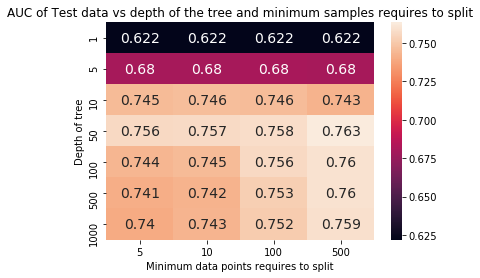

In [52]:
x_label='Minimum data points requires to split'
ylabel='Depth of tree'
title= 'AUC of Test data vs depth of the tree and minimum samples requires to split'
plot_tables_metrics(test_auc1, min_sample,depth,x_label,ylabel, title)

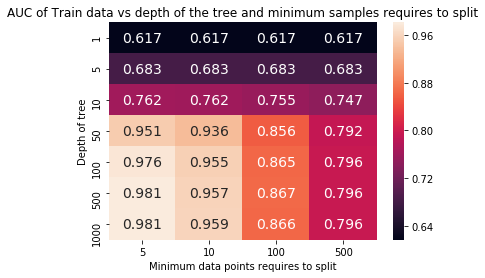

In [53]:
title= 'AUC of Train data vs depth of the tree and minimum samples requires to split'
plot_tables_metrics(train_auc1, min_sample,depth,x_label,ylabel, title)

**Observation**

We can see that when Tree depth is increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best tree depth and minimum data point required is 10 and 500 respectively which is giving train and test auc 0.747 and 0.743 respectively, which is very close so our model is well fitting.

In [55]:
from sklearn.tree import DecisionTreeClassifier
best_depth=10
best_minm_sample=500
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, min_samples_split=best_minm_sample)
clf.fit(training_count, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_count)
#acc = accuracy_score(test_target, pred[:,0], normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" best_depth: ",best_depth," AUC: ",auc)

 best_depth:  10  AUC:  0.801887775


In [56]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(training_count)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_count)

In [57]:
def plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count):
    # ROC AUC Curve
    y_true_train = train_traget
    y_probas_train = clf.predict_proba(training_count)
    y_true_test = test_target
    y_probas_test = clf.predict_proba(test_count)
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

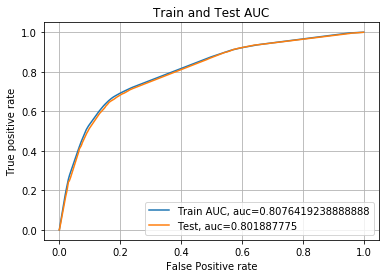

In [58]:
plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is overlapping on best hyperparamter depth =10 and minm points=500. And the diff of train and Test AUC is minimal so we can say that this model is well fit. If we need better performance than this we may need to try different complex models and add some new features.

In [59]:
# Plotting Confusion matrix on test data
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plotconfusionMatrix(y_true_test,clf,test_count):
    ax= plt.subplot()
    confm = confusion_matrix(y_true_test, clf.predict(test_count))
    sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix of Test data'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

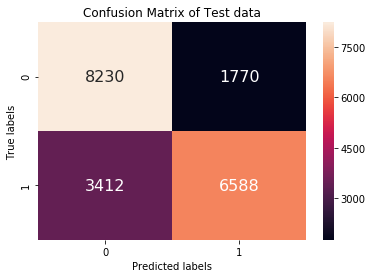

In [60]:
plotconfusionMatrix(y_true_test,clf,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.


# [5.1.1] Top 20 important features from SET 1


In [61]:
feature_data=pd.DataFrame(list(clf.feature_importances_),columns=['true_weights'])
features=(count_vect.get_feature_names())
feature_data['Feature_name']=features

In [62]:
feature_data.head(2)

,true_weights,Feature_name
0,0.0,abl
1,0.0,absolut


In [63]:
# Important features for both +ve and -ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=False)
feature_data.head(20)

,true_weights,Feature_name
570,0.193398,not
380,0.174344,great
254,0.092420,disappoint
80,0.087409,best
502,0.084212,love
238,0.066692,delici
372,0.037852,good
627,0.028722,perfect
296,0.028245,excel
317,0.026995,favorit


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
# Word cloud of Important features for both +ve and -ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for both +ve and -ve review")

**Observation**

We can see that all the positive and negative words in the above word cloud like amaz, satisfy, delici, disappoint, unfortun so these words are important features for both positive and negative review.

# [5.1.2] Graphviz visualization of Decision Tree on BOW, SET 1

In [64]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'

In [65]:
import graphviz
best_depth=3
best_minm_sample=500
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, min_samples_split=best_minm_sample)
clf.fit(training_count, train_traget)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

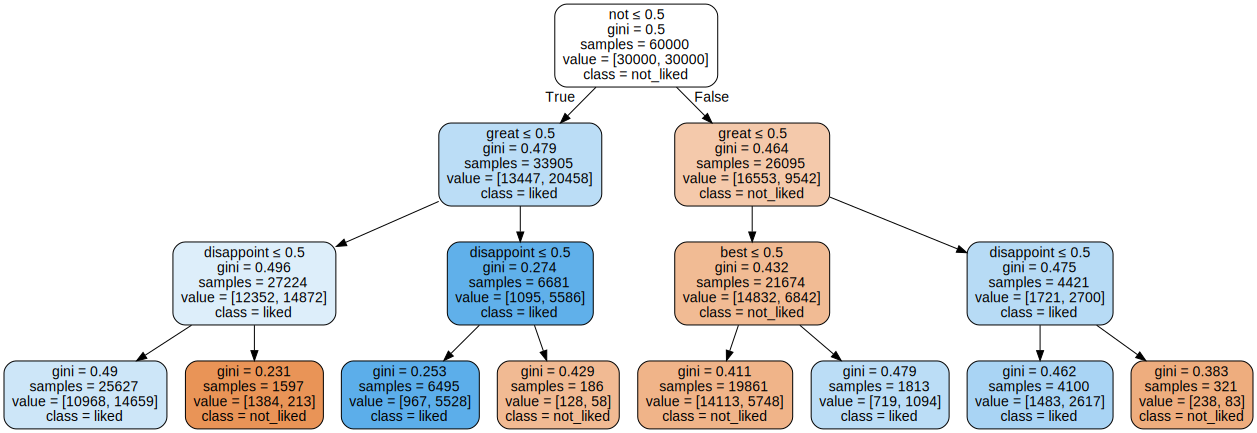

In [66]:
import graphviz
from sklearn import tree
#dot_data = tree.export_graphviz(clf, out_file=None) 

dot_data=tree.export_graphviz(clf, out_file=None,feature_names=count_vect.get_feature_names()
                              ,class_names=np.array(['not_liked','liked']), filled=True
                              , rounded=True,special_characters=True)

graph = graphviz.Source(dot_data)
graph

In [75]:


# from StringIO import StringIO
# out = StringIO()
out = tree.export_graphviz(clf,feature_names=count_vect.get_feature_names())
print (out)

digraph Tree {
node [shape=box] ;
0 [label="not <= 0.5\ngini = 0.5\nsamples = 60000\nvalue = [30000, 30000]"] ;
1 [label="great <= 0.5\ngini = 0.479\nsamples = 33905\nvalue = [13447, 20458]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="disappoint <= 0.5\ngini = 0.496\nsamples = 27224\nvalue = [12352, 14872]"] ;
1 -> 2 ;
3 [label="gini = 0.49\nsamples = 25627\nvalue = [10968, 14659]"] ;
2 -> 3 ;
4 [label="gini = 0.231\nsamples = 1597\nvalue = [1384, 213]"] ;
2 -> 4 ;
5 [label="disappoint <= 0.5\ngini = 0.274\nsamples = 6681\nvalue = [1095, 5586]"] ;
1 -> 5 ;
6 [label="gini = 0.253\nsamples = 6495\nvalue = [967, 5528]"] ;
5 -> 6 ;
7 [label="gini = 0.429\nsamples = 186\nvalue = [128, 58]"] ;
5 -> 7 ;
8 [label="great <= 0.5\ngini = 0.464\nsamples = 26095\nvalue = [16553, 9542]"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
9 [label="best <= 0.5\ngini = 0.432\nsamples = 21674\nvalue = [14832, 6842]"] ;
8 -> 9 ;
10 [label="gini = 0.411\nsamp

In [76]:
clf.tree_.feature

array([570, 380, 254,  -2,  -2, 254,  -2,  -2, 380,  80,  -2,  -2, 254,
        -2,  -2], dtype=int64)

In [77]:
clf.tree_.value

array([[[30000., 30000.]],

       [[13447., 20458.]],

       [[12352., 14872.]],

       [[10968., 14659.]],

       [[ 1384.,   213.]],

       [[ 1095.,  5586.]],

       [[  967.,  5528.]],

       [[  128.,    58.]],

       [[16553.,  9542.]],

       [[14832.,  6842.]],

       [[14113.,  5748.]],

       [[  719.,  1094.]],

       [[ 1721.,  2700.]],

       [[ 1483.,  2617.]],

       [[  238.,    83.]]])

### skompile and graphViz to export tree script into file

In [79]:
from skompiler import skompile
skompile(clf.predict).to('python/code')

'(((1 if x[254] <= 0.5 else 0) if x[380] <= 0.5 else 1 if x[254] <= 0.5 else\n    0) if x[570] <= 0.5 else (0 if x[80] <= 0.5 else 1) if x[380] <= 0.5 else\n    1 if x[254] <= 0.5 else 0)\n'

**Observation**

We can see that all the positive and negative words in the above Tree like great, best , delici, disappoint, not so these words are important features for both positive and negative review which is giving maximum information gain. 

# Feature Engineering

Creating 4 new features using word and character len of description and summary columns

In [ ]:
import pandas as pd
data=pd.DataFrame(training_count)
data.head(3)

In [ ]:
data.shape

In [ ]:
#Train data
# word len of description and summary columns
data['description_len'] = train_text_data['CleanedText'].apply(lambda x : len(x.split()))
data['summary_len'] = train_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data['description_char_len'] = train_text_data['CleanedText'].apply(len)
data['Summary_char_len'] = train_text_data['Summary'].apply(len)

In [ ]:
data.head(1)

In [ ]:
data.shape

In [ ]:
#Test data
# word len of description and summary columns
data_test=pd.DataFrame(test_count)
data_test['description_len'] = test_text_data['CleanedText'].apply(lambda x : len(x.split()))
data_test['summary_len'] = test_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data_test['description_char_len'] = test_text_data['CleanedText'].apply(len)
data_test['Summary_char_len'] = test_text_data['Summary'].apply(len)
data_test.head(1)

In [ ]:
data_test.shape

In [ ]:
# with new features

best_depth=10
best_minm_sample=500
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, min_samples_split=best_minm_sample)
clf.fit(data, train_traget)

# # Prediction on Test data
pred = clf.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" best_depth: ",best_depth," AUC: ",auc)

**Observation**

After adding the 4 new features, performance has reduced, earlier we have 80% AUC and after feature engineering we are getting 74%, may be we need to tune the hyperparameter further.

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(2,3),min_df=10,max_features=1000)
training_counts = tf_idf_vect.fit_transform(train_text_data['CleanedText'])
cv_counts = tf_idf_vect.transform(cv_text_data['CleanedText'])
test_counts = tf_idf_vect.transform(test_text_data['CleanedText'])

In [ ]:

print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
# converting sparse vector to dense vector
training_count=training_counts.toarray()
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()

In [ ]:
train_traget=train_text_data['Score'].astype('int')
cv_target=cv_text_data['Score'].astype('int')
test_target=test_text_data['Score'].astype('int')

In [ ]:
# Compute train AUC also

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
depth=[1, 5, 10, 50, 100, 500, 1000]
min_sample=[5, 10, 100, 500]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(depth):
    for j in tqdm(min_sample):
        # instantiate learning model
        clf = DecisionTreeClassifier(criterion='gini', max_depth=i, min_samples_split=j)
        # fitting the model on crossvalidation train
        clf.fit(training_count, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_count)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(training_count))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

In [ ]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (7, 4))
train_auc1=np.reshape(train_auc, (7, 4))

In [ ]:
x_label='Minimum data points requires to split'
ylabel='Depth of tree'
title= 'AUC of Test data vs depth of the tree and minimum samples requires to split'
plot_tables_metrics(test_auc1, min_sample,depth,x_label,ylabel, title)

In [ ]:
title= 'AUC of Train data vs depth of the tree and minimum samples requires to split'
plot_tables_metrics(train_auc1, min_sample,depth,x_label,ylabel, title)

**Observation**

We can see that when Tree depth is increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best tree depth and minimum data point required is 500 and 500 respectively which is giving train and test auc 0.79 and 0.743 respectively, which is bit close so our model is overall fitting.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
best_depth=500
best_minm_sample=500
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, min_samples_split=best_minm_sample)
clf.fit(training_count, train_traget)

# Prediction on Test data
pred = clf.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" best_depth: ",best_depth," AUC: ",auc)

In [ ]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(training_count)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_count)

In [ ]:
plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count)
plt.show()

**Observation**
We can see that the Train and Test ROC plot is not overlapping on best hyperparamter depth =500 and minm points=500. And the diff of train and Test AUC is bit more so we can say that this model is overfitting, so to fix this overfitting we need to increase the traing data size. If we need better performance than this we may need to try different complex models and add some new features.

In [ ]:
# Plotting Confusion matrix on test data
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plotconfusionMatrix(y_true_test,clf,test_count):
    ax= plt.subplot()
    confm = confusion_matrix(y_true_test, clf.predict(test_count))
    sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix of Test data'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

In [ ]:
plotconfusionMatrix(y_true_test,clf,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation
feature_data=pd.DataFrame(list(clf.feature_importances_),columns=['true_weights'])
features=(tf_idf_vect.get_feature_names())
feature_data['Feature_name']=features

In [ ]:
# Important features for both +ve and -ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=False)
feature_data.head(20)

In [ ]:
# Word cloud of Important features for both +ve and -ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for both +ve and -ve review")

**Observation**


We can see that all the positive and negative words in the above word cloud like amaz, satisfy, delici, disappoint, unfortun so these words are important features for both positive and negative review.

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation
import graphviz
best_depth=3
best_minm_sample=500
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, min_samples_split=best_minm_sample)
clf.fit(training_count, train_traget)

In [ ]:
import graphviz
from sklearn import tree
#dot_data = tree.export_graphviz(clf, out_file=None) 

dot_data=tree.export_graphviz(clf, out_file=None,feature_names=tf_idf_vect.get_feature_names()
                              ,class_names=np.array(['not_liked','liked']), filled=True
                              , rounded=True,special_characters=True)

graph = graphviz.Source(dot_data)
graph

**Observation**

We can see that all the positive and negative words in the above Tree like high recommend, absolut love , never buy, veri disappoint, wast money so these words are important features for both positive and negative review which is giving maximum information gain.

# Feature Engineering

In [ ]:
import pandas as pd
data=pd.DataFrame(training_count)
data.head(3)

In [ ]:
#Train data
# word len of description and summary columns
data['description_len'] = train_text_data['CleanedText'].apply(lambda x : len(x.split()))
data['summary_len'] = train_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data['description_char_len'] = train_text_data['CleanedText'].apply(len)
data['Summary_char_len'] = train_text_data['Summary'].apply(len)

In [ ]:
#Test data
# word len of description and summary columns
data_test=pd.DataFrame(test_count)
data_test['description_len'] = test_text_data['CleanedText'].apply(lambda x : len(x.split()))
data_test['summary_len'] = test_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data_test['description_char_len'] = test_text_data['CleanedText'].apply(len)
data_test['Summary_char_len'] = test_text_data['Summary'].apply(len)
data_test.head(1)

In [ ]:
# with new features

best_depth=500
best_minm_sample=500
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, min_samples_split=best_minm_sample)
clf.fit(data, train_traget)

# # Prediction on Test data
pred = clf.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" best_depth: ",best_depth," AUC: ",auc)

**Observation**

After adding the 4 new features, performance has reduced, earlier we have 76% AUC and after feature engineering we are getting 74%, may be we need to tune the hyperparameter further.

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation


In [ ]:
# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
train_traget=train_avg_w2v_data['Score'].astype('int')
cv_target=cv_avg_w2v_data['Score'].astype('int')
test_target=test_avg_w2v_data['Score'].astype('int')

train_data = train_avg_w2v_data.iloc[:,:-2]
cv_data = cv_avg_w2v_data.iloc[:,:-2]
test_data = test_avg_w2v_data.iloc[:,:-2]

In [ ]:
train_avg_w2v_data.head(1)

In [ ]:
# Compute train AUC also

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
depth=[1, 5, 10, 50, 100, 500, 1000]
min_sample=[5, 10, 100, 500]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(depth):
    for j in tqdm(min_sample):
        # instantiate learning model
        clf = DecisionTreeClassifier(criterion='gini', max_depth=i, min_samples_split=j)
        # fitting the model on crossvalidation train
        clf.fit(train_data, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_data)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(train_data))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

In [ ]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (7, 4))
train_auc1=np.reshape(train_auc, (7, 4))

In [ ]:
x_label='Minimum data points requires to split'
ylabel='Depth of tree'
title= 'AUC of Test data vs depth of the tree and minimum samples requires to split'
plot_tables_metrics(test_auc1, min_sample,depth,x_label,ylabel, title)

In [ ]:
title= 'AUC of Train data vs depth of the tree and minimum samples requires to split'
plot_tables_metrics(train_auc1, min_sample,depth,x_label,ylabel, title)

**Observation**

We can see that when Tree depth is increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best tree depth and minimum data point required is 10 and 500 respectively which is giving train and test auc 0.54 and 0.50 respectively, which is very close so our model is well fitting.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
best_depth=10
best_minm_sample=500
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, min_samples_split=best_minm_sample)
clf.fit(train_data, train_traget)

# Prediction on Test data
pred = clf.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" best_depth: ",best_depth," AUC: ",auc)

In [ ]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(train_data)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_data)

In [ ]:
plot_train_test_ROC(y_true_train,clf,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is bit overlapping on best hyperparamter depth =10 and minm points=500. And the diff of train and Test AUC is minimal but overall auc is low so we can say that this model is underfitting . If we need better performance than this we may need to try different complex models and add some new features.

In [ ]:
plotconfusionMatrix(y_true_test,clf,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

In [ ]:
# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
train_traget=train_tfidf_w2v_data['Score'].astype('int')
cv_target=cv_tfidf_w2v_data['Score'].astype('int')
test_target=test_tfidf_w2v_data['Score'].astype('int')

train_data = train_tfidf_w2v_data.iloc[:,:-2]
cv_data = cv_tfidf_w2v_data.iloc[:,:-2]
test_data = test_tfidf_w2v_data.iloc[:,:-2]

In [ ]:
# Compute train AUC also

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
depth=[1, 5, 10, 50, 100, 500, 1000]
min_sample=[5, 10, 100, 500]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(depth):
    for j in tqdm(min_sample):
        # instantiate learning model
        clf = DecisionTreeClassifier(criterion='gini', max_depth=i, min_samples_split=j)
        # fitting the model on crossvalidation train
        clf.fit(train_data, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_data)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(train_data))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

In [ ]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (7, 4))
train_auc1=np.reshape(train_auc, (7, 4))

In [ ]:
x_label='Minimum data points requires to split'
ylabel='Depth of tree'
title= 'AUC of Test data vs depth of the tree and minimum samples requires to split'
plot_tables_metrics(test_auc1, min_sample,depth,x_label,ylabel, title)

In [ ]:
title= 'AUC of Train data vs depth of the tree and minimum samples requires to split'
plot_tables_metrics(train_auc1, min_sample,depth,x_label,ylabel, title)

**Observation**

We can see that when Tree depth is increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best tree depth and minimum data point required is 10 and 500 respectively which is giving train and test auc 0.54 and 0.50 respectively, which is very close so our model is well fitting.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
best_depth=10
best_minm_sample=500
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, min_samples_split=best_minm_sample)
clf.fit(train_data, train_traget)

# Prediction on Test data
pred = clf.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" best_depth: ",best_depth," AUC: ",auc)

In [ ]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(train_data)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_data)

In [ ]:
plot_train_test_ROC(y_true_train,clf,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is bit overlapping on best hyperparamter depth =10 and minm points=500. And the diff of train and Test AUC is minimal but overall auc is low so we can say that this model is underfitting . If we need better performance than this we may need to try different complex models and add some new features.

In [ ]:
plotconfusionMatrix(y_true_test,clf,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best depth","Best min sample", "AUC"]

x.add_row(["BOW", "Decision Tree", 10,500, 0.81])
x.add_row(["BOW with feature engg", "Decision Tree", 10,500, 0.74])
x.add_row(["TFIDF", "Decision Tree", 500,500, 0.78])
x.add_row(["TFIDF with feature engg", "Decision Tree", 500,500, 0.74])
x.add_row(["AvgWord2Vec", "Decision Tree", 10,500, 0.51])
x.add_row(["TFIDFWord2Vec", "Decision Tree", 10,500, 0.50])
print(x)

**Observation**

We can see that with all 6 type of models Simple BOW vectorizer performing better with maximum AUC 81% on test data.TFIDF based vectorizer gave 2nd best solution with aprrox same AUC, after adding 4 new features performance of both BOW and TFIDF have reduced. On the other word2vec vectorizer on both avg and TFIDF performing worst and similar to random model.